# Fully connected network 

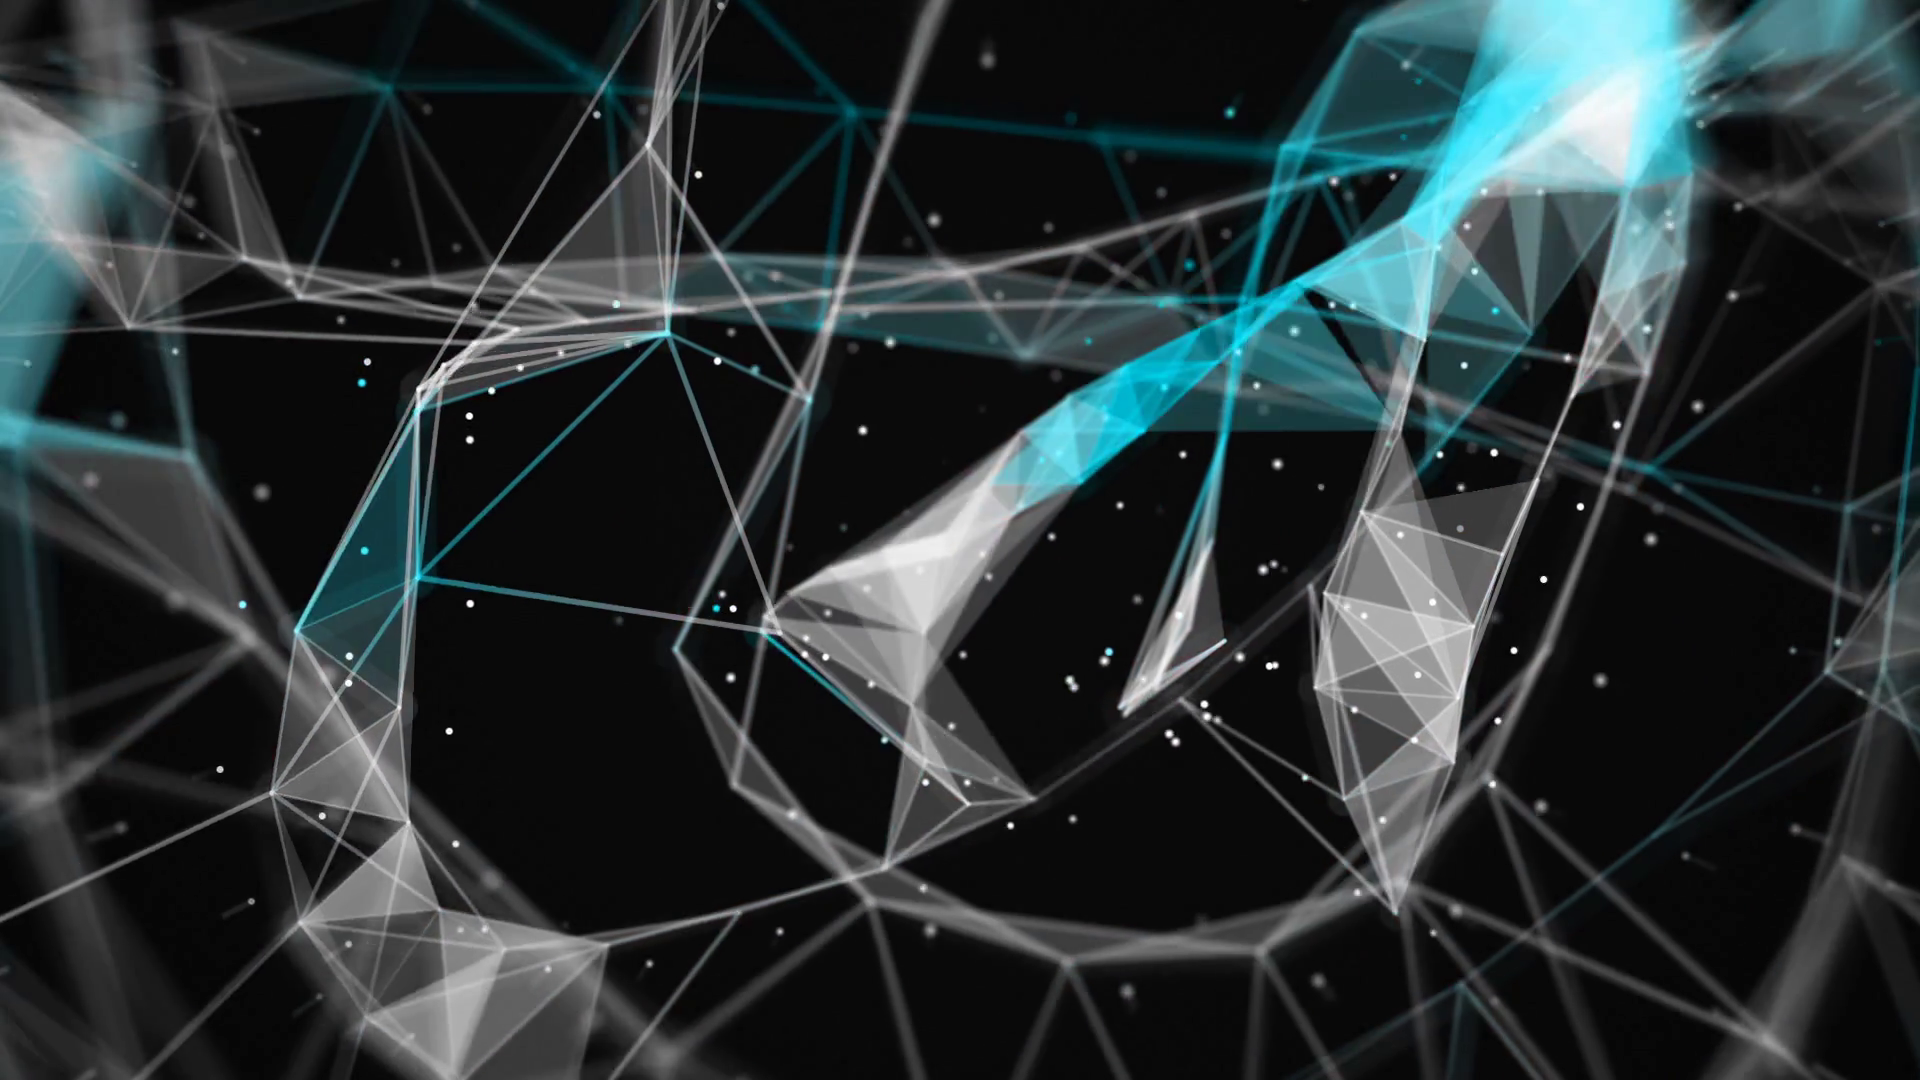

In [1]:
import os
from IPython.display import Image
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "network1.png", width=550)

In [2]:
# first we will load all the allowed libraries and start from scratch 
# please to notice that we wont load the numpy library 

In [3]:
from pathlib import Path 
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch 
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
import os

In [4]:
#MNIST data 

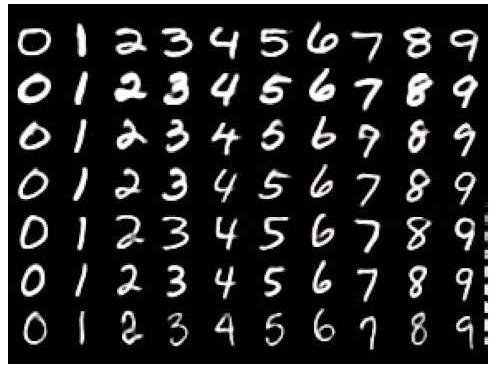

In [5]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "mnist1.png", width = 550)

In [6]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [7]:
def get_data():
    
    path = datasets.download_data(MNIST_URL, ext = ".gz")
    
    with gzip.open(path, "rb") as f:
        
        ((x_tr, y_tr),(x_val,y_val),_) = pickle.load(f, encoding = "latin-1")
        
        torch_data = map(tensor, (x_tr, y_tr, x_val, y_val))
        
    return torch_data

In [8]:
(x_tr, y_tr, x_val, y_val) = get_data()

In [9]:
# mean and standard deviation of the data 

In [10]:
def data_info(x, check = False):
    
    if check == True:
    
        d = {1: ["Mean", x.mean()], 2: ["St.Dev.", x.std()]}
                
        print("{:<8} {:<15} {:<10}".format("N",'Moment','Value'))
        
        for key, value in d.items():
            
            label, number = value[0], "{0:.4f}".format(value[1])
            
            print("{:<8} {:<15} {:<10}".format(key, label, number))
    
    return (x.mean(), x.std())

In [11]:
data_info(x_tr), data_info(x_val)

((tensor(0.1304), tensor(0.3073)), (tensor(0.1287), tensor(0.3050)))

In [12]:
data_info(x_tr, True)

N        Moment          Value     
1        Mean            0.1304    
2        St.Dev.         0.3073    


(tensor(0.1304), tensor(0.3073))

In [13]:
##BOLD TEXT##

# Normalization 

In [14]:
## here we will normalize the data to have zero mean and standard deviation = 1

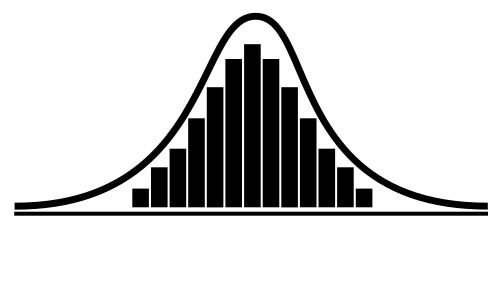

In [15]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "gauss1.png", width = 550)

In [16]:
def data_norm(x, mean, std):
    
    if not std == 0:
    
        data_norm = (x - mean)/std
        
        return data_norm 
        
    else:
        
        print("There is a singularity since standard deviation is ", std)   
        
        return None 

In [17]:
# please to note the order of normaliztion - first normlaize validation data to the meand and standard deviation
# of the train data and only then normalize the training set of data

In [18]:
x_val = data_norm(x_val, x_tr.mean(), x_tr.std())

In [19]:
data_info(x_val, True)

N        Moment          Value     
1        Mean            -0.0057   
2        St.Dev.         0.9924    


(tensor(-0.0057), tensor(0.9924))

In [20]:
data_info(x_tr, True)

N        Moment          Value     
1        Mean            0.1304    
2        St.Dev.         0.3073    


(tensor(0.1304), tensor(0.3073))

In [21]:
def value_near_zero(val, tolerance = 1e-3, check = False):
    int_near_val = int(round(val.mean().item()))
    if val.abs() >= tolerance:
        print("The value {} is not near 0 within tolerance {} and instead close to {}"
              .format(val, tolerance, int_near_val))
    elif val.abs()< tolerance:
        #val.abs() < tolerance, f"Near zero:{val}"
        if check == True:
            print("The value {} is near 0 within tolerance {}".format(val, tolerance))

In [22]:
value_near_zero(x_tr.mean(), check = True)

The value 0.1304190456867218 is not near 0 within tolerance 0.001 and instead close to 0


In [23]:
value_near_zero(x_tr.std() - 1.0, check = True)

The value -0.6927101612091064 is not near 0 within tolerance 0.001 and instead close to -1


In [24]:
value_near_zero(x_val.mean(), check = True)

The value -0.005747819785028696 is not near 0 within tolerance 0.001 and instead close to 0


In [25]:
value_near_zero(x_val.std()-1, check = True)

The value -0.007566630840301514 is not near 0 within tolerance 0.001 and instead close to 0


# Convololution network architecture 

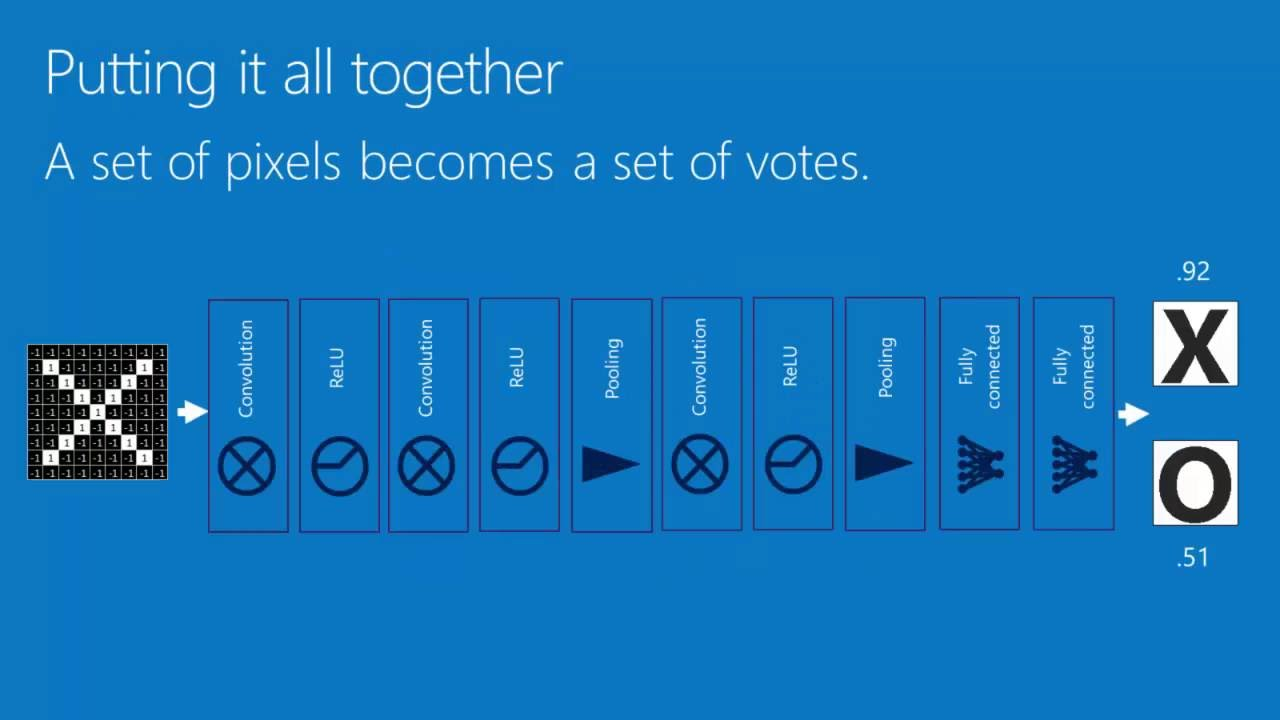

In [26]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "cnn1.jpeg", width = 600)

Notes from https://pouannes.github.io/blog/initialization/

Forward-propagation

For each layer l the response is written as:

\begin{equation}
\mathbf{y}_{l} = W_{l}\mathbf{x}_{l} + \mathbf{b}_{l}
\end{equation}

yl=Wlxl+bl


Do you notice that yl,xl
and bl are in bold? That means those are vectors. I know, it can be confusing. It’s to make you pay attention! Or so my teachers keep repeating to me… Anyway, here’s the definition of each term of this equation:

xl is a nl-by-1 vector that represents the activations of the previous layer yl−1 that were passed through the activation function f , so we have xl=f(yl−1)
nl is the number of activations of layer l

Wl is a dl-by-nl matrix of all the connections from layer l−1 to layer l , with dl the number of filters of the convolutional layer (or equivalently the number of channels).

bl is the vector of biases of layer l (that are usually initialized to 0).

yl, as mentioned before, is the vector of activations of layer l before they go though the activation function.

In [27]:
x_tr.shape[0], x_tr.shape[1]

(50000, 784)

In [28]:
y_tr.shape, y_tr.min(), y_tr.max()

(torch.Size([50000]), tensor(0), tensor(9))

# Dimensions

In [29]:
n , m = x_tr.shape[0], x_tr.shape[1]

In [30]:
c = (y_tr.max() -  y_tr.min() + 1).item()

In [31]:
n, m , c

(50000, 784, 10)

In [32]:
# here we go with hidden connections 

In [33]:
nh = 50 

In [34]:
# We will have to fill math details from Kaiming initialization but 
# basically we have to normalize the data by the factor sqrt[2/n_v] in the forward pass 
# and by the factor sqrt(2/h_h) in the backward pass

In [35]:
# here is the first weight matrix 
torch.manual_seed(37)
data_info(torch.randn(m, nh), True)

N        Moment          Value     
1        Mean            -0.0009   
2        St.Dev.         0.9970    


(tensor(-0.0009), tensor(0.9970))

In [36]:
# with kaiming normalization factor math.sqrt(2/m) -> subscript "kai"
w1_kai = torch.randn(m, nh)*math.sqrt(2/m)
# naive implementation of the weight matrix without normlization -> subscript "nai"
w1_nai = torch.randn(m, nh)

In [37]:
w1_kai.shape

torch.Size([784, 50])

In [38]:
x_tr.shape, x_val.shape

(torch.Size([50000, 784]), torch.Size([10000, 784]))

In [39]:
##torch.randn??

In [40]:
# randn(*sizes, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor
# Returns a tensor filled with random numbers from a normal distribution
# with mean `0` and variance `1` (also called the standard normal
# distribution).

In [41]:
# here we go with the bias
b1 = torch.zeros(nh)

In [42]:
# I suspect that hidden layers = the number of filters of convolutional layers = 
# or equivalently the number of channels 

In [43]:
b1.shape

torch.Size([50])

In [44]:
data_info(w1_kai, True)

N        Moment          Value     
1        Mean            -0.0001   
2        St.Dev.         0.0502    


(tensor(-0.0001), tensor(0.0502))

In [45]:
data_info(w1_nai, True)

N        Moment          Value     
1        Mean            -0.0000   
2        St.Dev.         1.0044    


(tensor(-2.6610e-05), tensor(1.0044))

In [46]:
data_info(x_val, True)

N        Moment          Value     
1        Mean            -0.0057   
2        St.Dev.         0.9924    


(tensor(-0.0057), tensor(0.9924))

In [47]:
#Layers

In [48]:
x_tr.shape

torch.Size([50000, 784])

In [49]:
w1_kai.shape

torch.Size([784, 50])

In [50]:
x_val.shape

torch.Size([10000, 784])

In [51]:
def lin(x, w, b):
    return x @ w + b

In [52]:
# recall in pytorch @ = matrix multiplication 

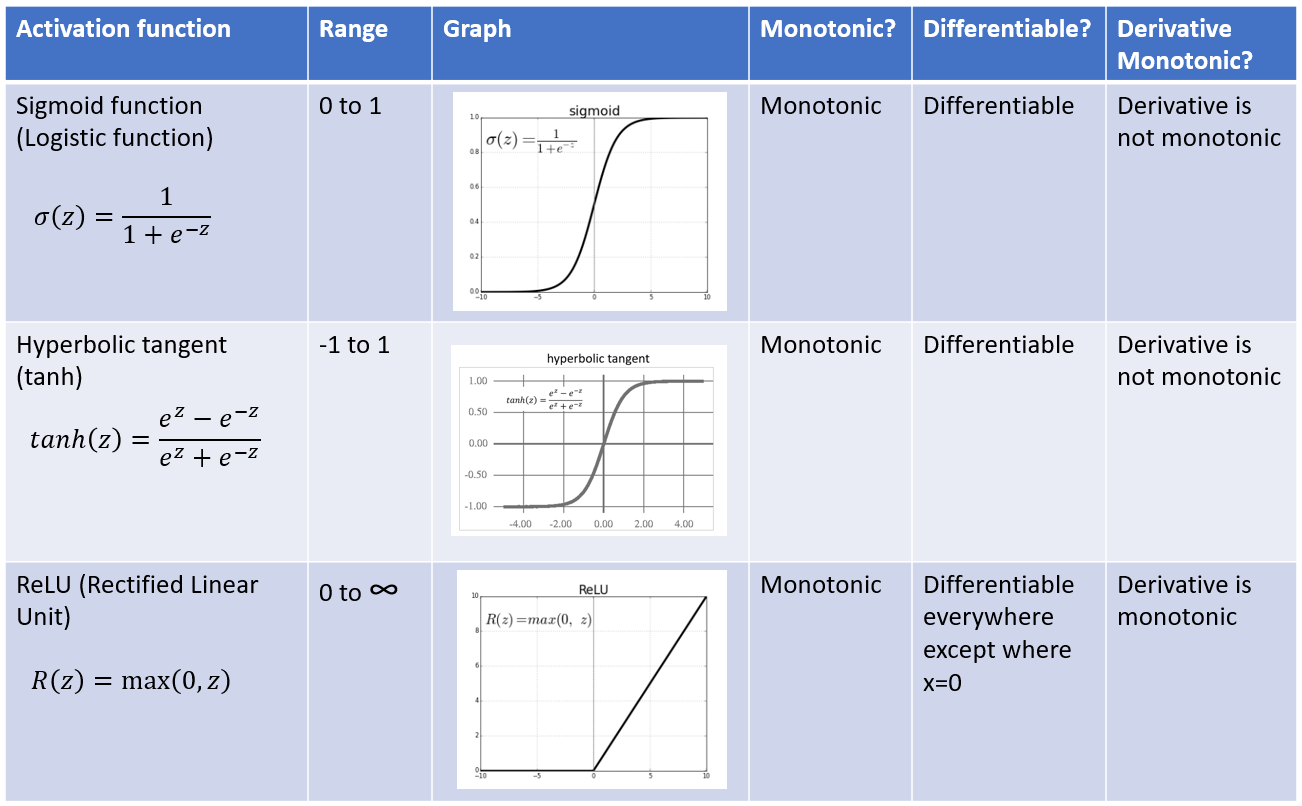

In [53]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "relu1.png", width = 600)

In [54]:
def relu(x):
    return x.clamp_min(0.0)

In [55]:
arr = torch.arange(-10.0,10.0 + 1)
arr, type(arr)

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]), torch.Tensor)

In [56]:
arr_relu = arr.clamp_min(0.0)
arr_relu

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,
         4.,  5.,  6.,  7.,  8.,  9., 10.])

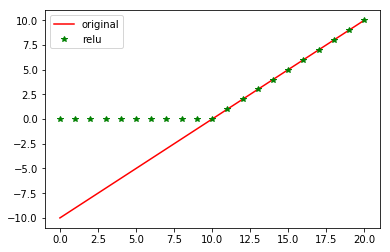

In [57]:
plt.plot(arr.numpy(), 'r', label = "original")
plt.plot(arr_relu.numpy(), 'g*', label = "relu")
plt.legend()
plt.show()

In [58]:
# there is an exception in here to allow us use numpy only once
import numpy as np
x = torch.arange(-10.0,10.0 + 1)
x_step_data = [np.heaviside(elem, 0)*elem for elem in x]

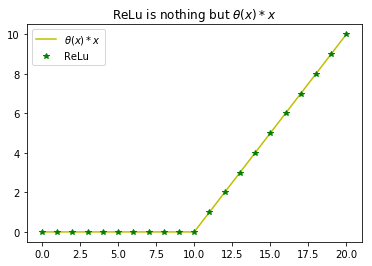

In [59]:
plt.plot(x_step_data, 'y-', label = r'$\theta(x)*x$')
plt.plot(arr_relu.numpy(), 'g*', label = "ReLu")
plt.legend()
plt.title("ReLu is nothing but "+ r"$\theta(x)*x$")
plt.show()

In [60]:
num_imgs = 5
image_arr = []
image_arr_relu = []
for kk in range(num_imgs):
    image_arr.append(x_tr[kk].numpy())
    image_arr_relu.append(relu(x_tr[kk]).numpy())

In [61]:
size = int(math.sqrt(x_tr.shape[1]))
size

28

In [62]:
image_arr_resh = [image_arr[kk].reshape(size,size) for kk in range(num_imgs)]
image_arr_resh_relu = [image_arr_relu[kk].reshape(size,size) for kk in range(num_imgs)]

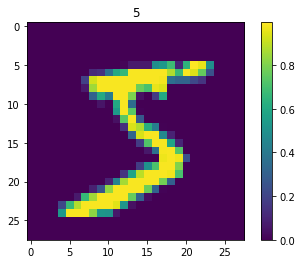

In [63]:
plt.title(str(y_tr[0].item()))
plt.imshow(image_arr_resh[0])
plt.colorbar()
plt.show()

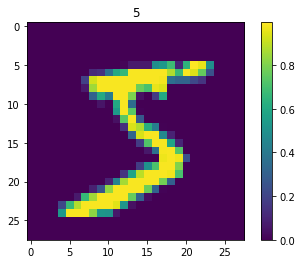

In [64]:
plt.title(str(y_tr[0].item()))
plt.imshow(image_arr_resh_relu[0])
plt.colorbar()
plt.show()

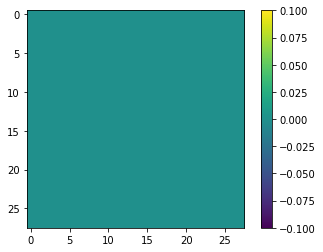

In [65]:
plt.imshow(image_arr_resh[0] - image_arr_resh_relu[0])
plt.colorbar()
plt.show()

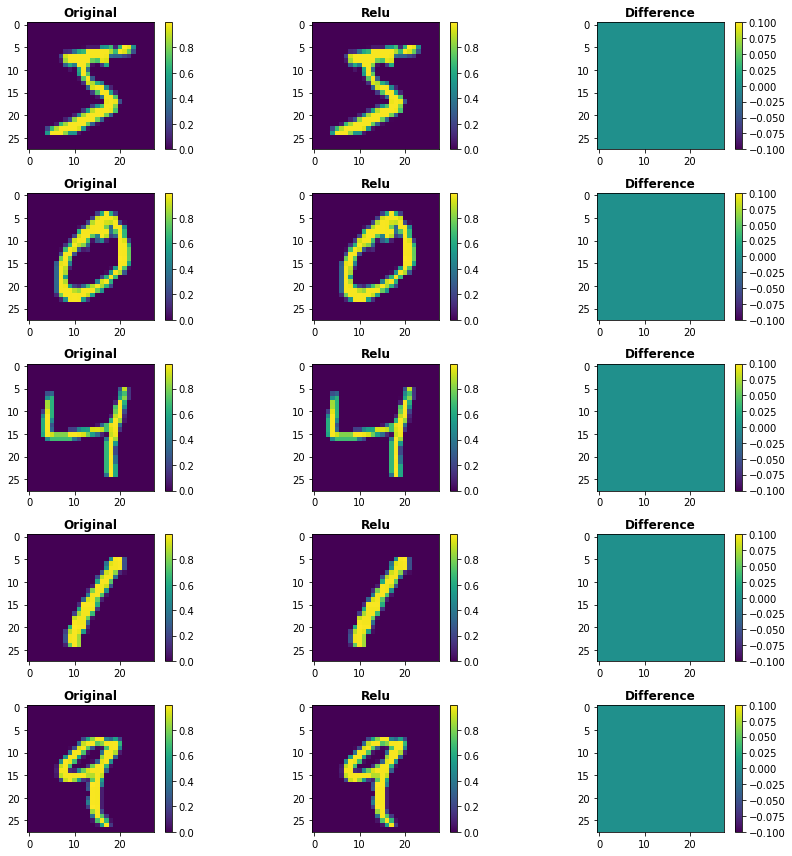

In [66]:
fig = plt.figure(figsize=(12,12)) 

label_arr = ["Original", "Relu", "Difference"]

col = len(label_arr)

img_arr = []

for kk in range(num_imgs):
    
    img_arr.append([image_arr_resh[kk], 
                    image_arr_resh_relu[kk], 
                    image_arr_resh[kk] - image_arr_resh_relu[kk]])

for kk in range(1, col + 1): 
    
    for mm in range(1, num_imgs + 1):
        
        ax = fig.add_subplot(num_imgs, col, kk + (mm-1)*col)
        
        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        
        ax.set_title(label_arr[kk - 1], fontweight='bold')
        
        img = ax.imshow(img_arr[mm - 1][kk - 1])
        
        plt.colorbar(img, orientation="vertical", fraction=0.045, anchor=(1.0,0.0))
    
plt.show()

In [67]:
t1 = lin(x_tr, w1_kai, b1)

In [68]:
x_val.shape, w1_kai.shape, b1.shape, t1.shape 

(torch.Size([10000, 784]),
 torch.Size([784, 50]),
 torch.Size([50]),
 torch.Size([50000, 50]))

In [69]:
data_info(t1, True)

N        Moment          Value     
1        Mean            -0.0077   
2        St.Dev.         0.4713    


(tensor(-0.0077), tensor(0.4713))

In [70]:
t1.shape

torch.Size([50000, 50])

In [71]:
num_imgs = 5
t_arr = []
for kk in range(num_imgs):
    t_arr.append(t1[kk].numpy())

In [72]:
ts = t1.shape[1]
ts

50

In [73]:
t_arr_resh = [t_arr[kk].reshape(10,int(ts/10)) for kk in range(num_imgs)]

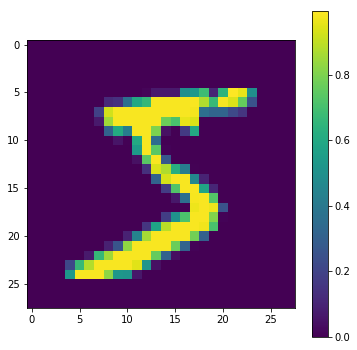

In [74]:
fig = plt.figure(figsize=(6,6)) 
plt.imshow(image_arr_resh[0])
plt.colorbar()
plt.show()

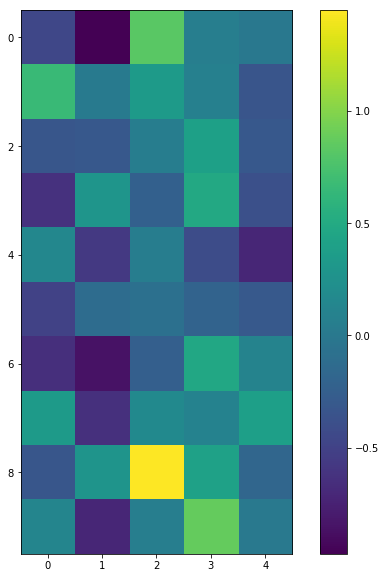

In [75]:
fig = plt.figure(figsize=(10,10)) 
plt.imshow(t_arr_resh[0])
plt.colorbar()
plt.show()

In [76]:
from torch.nn import init

In [77]:
#init??

In [78]:
w1 = torch.zeros(m, nh)
#init.kaiming_normal_??

In [79]:
#Pytorch documentation

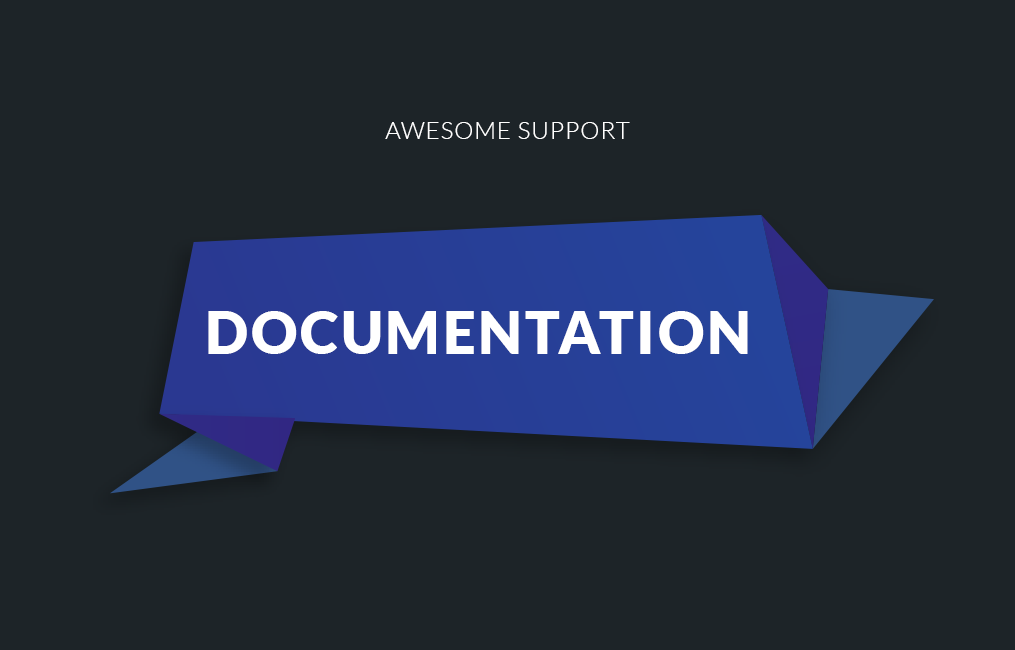

In [80]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "doc_image1.png", width=700)

In [81]:
# Pytorch documentation:
# def kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu'):
#     r"""Fills the input `Tensor` with values according to the method
#     described in `Delving deep into rectifiers: Surpassing human-level
#     performance on ImageNet classification` - He, K. et al. (2015), using a
#     normal distribution. The resulting tensor will have values sampled from
#     :math:`\mathcal{N}(0, \text{std})` where

#     .. math::
#         \text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan\_in}}}

#     Also known as He initialization.

\begin{equation}
\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan\_in}}}
\end{equation}

In [82]:
w1 = torch.zeros(m, nh)

In [83]:
w1_kai = init.kaiming_normal_(w1, mode = "fan_out")

In [84]:
# the reason for mode = "fan_out" is due to the transpose matrix

In [85]:
w1.shape

torch.Size([784, 50])

In [86]:
t2 = relu(lin(x_val, w1, b1))

In [87]:
t2.shape

torch.Size([10000, 50])

In [88]:
data_info(t2, True)

N        Moment          Value     
1        Mean            0.5455    
2        St.Dev.         0.8971    


(tensor(0.5455), tensor(0.8971))

In [89]:
def relu_shift(x):
    x_shift = x.clamp_min(0.0) - 0.5
    return x_shift

In [90]:
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [91]:
t3 = relu_shift(lin(x_val, w1, b1))

In [92]:
data_info(t3, True)

N        Moment          Value     
1        Mean            0.0895    
2        St.Dev.         0.8572    


(tensor(0.0895), tensor(0.8572))

# Layers: forward pass

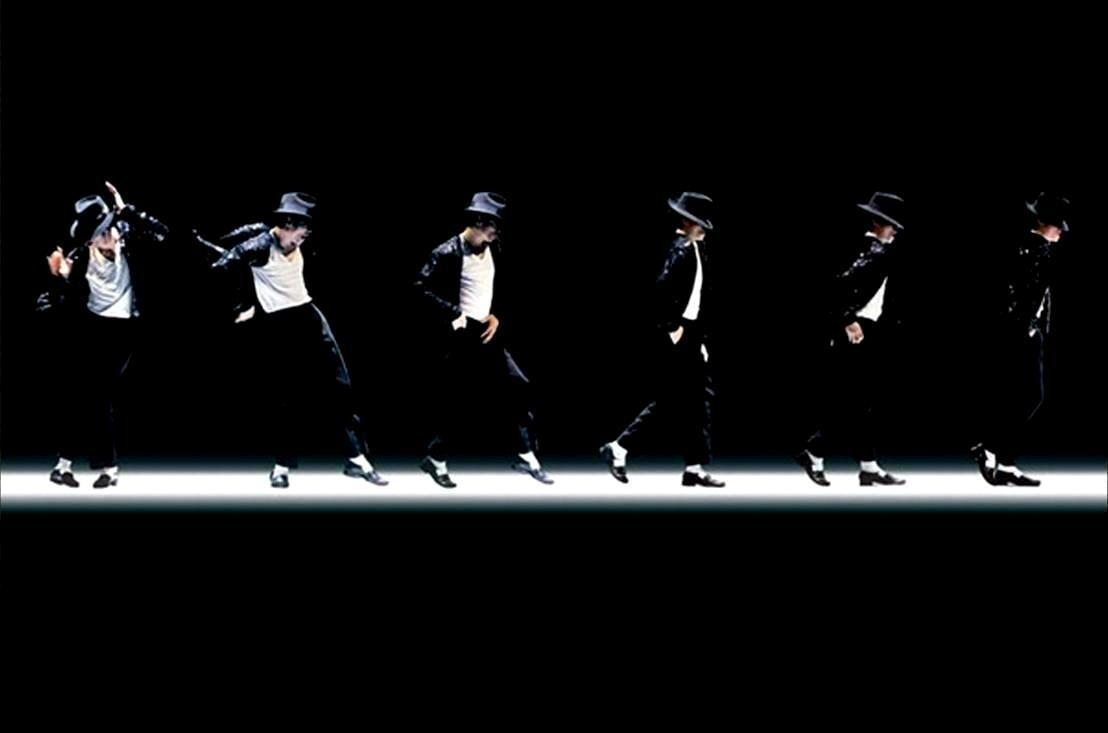

In [93]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "jackson_walk1.jpeg", width=500)

In [94]:
# forward pass: layer 1
w1 = torch.randn(m, nh) * math.sqrt(2.0/m)
b1 = torch.zeros(nh)
# forward pass: layer 2
w2 = torch.randn(nh, 1) * math.sqrt(2.0/nh)
b2 = torch.zeros(1)

In [95]:
def model(x):
    
    l1 = lin(x, w1, b1)
    
    l2 = relu_shift(l1)
    
    l3 = lin(l2, w2, b2)
    
    return l3

In [96]:
model(x_val).shape, x_val.shape

(torch.Size([10000, 1]), torch.Size([10000, 784]))

In [97]:
model(x_val)

tensor([[-0.0310],
        [ 0.4127],
        [ 0.2074],
        ...,
        [ 0.6026],
        [-0.6678],
        [-0.2396]])

In [98]:
%timeit -n 10 T=model(x_val)

6.86 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Loss function: mean square error

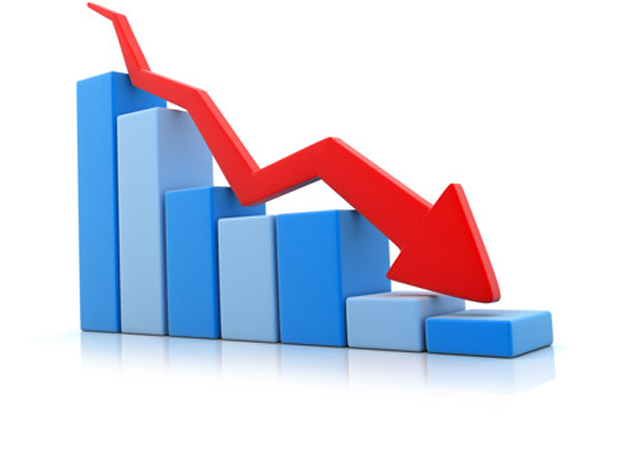

In [99]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "loss1.jpeg", width=500)

In [100]:
model(x_val).squeeze(-1).shape, y_val.shape

(torch.Size([10000]), torch.Size([10000]))

In [101]:
model(x_val).shape

torch.Size([10000, 1])

In [102]:
model(x_val).squeeze(-1), y_val

(tensor([-0.0310,  0.4127,  0.2074,  ...,  0.6026, -0.6678, -0.2396]),
 tensor([3, 8, 6,  ..., 5, 6, 8]))

In [103]:
def mse(out, targ):
    
    res = (out.squeeze(-1) - targ).pow(2).mean()
    
    return res

In [104]:
y_val, y_tr = y_val.float(), y_tr.float()

In [105]:
y_val, y_tr

(tensor([3., 8., 6.,  ..., 5., 6., 8.]),
 tensor([5., 0., 4.,  ..., 8., 4., 8.]))

In [106]:
pred = model(x_val).squeeze(-1)
print(pred.shape)
print(y_val.shape)

torch.Size([10000])
torch.Size([10000])


In [107]:
error = mse(pred, y_val)
error

tensor(25.4058)

# Layers: backward pass

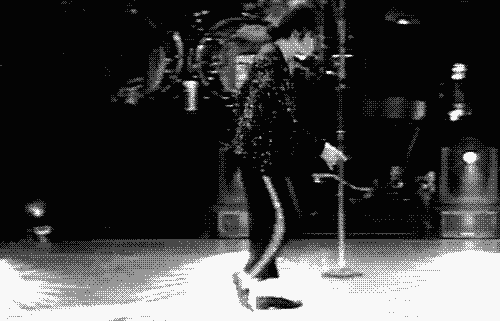

In [108]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "jackson_walk2.gif", width=500)

In [109]:
arr = torch.arange(-10,11)
arr_relu = arr.clamp_min(0.0)
grad_arr = [(elem>0).float().item() for elem in arr]

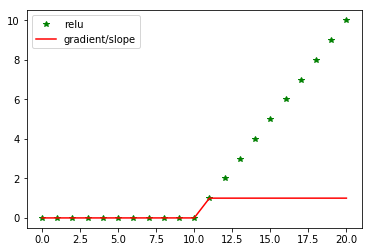

In [110]:
plt.plot(arr_relu.numpy(), 'g*', label = "relu")
plt.plot(grad_arr, 'r', label = "gradient/slope")
plt.legend()
plt.show()

In [111]:
arr_relu, torch.tensor(grad_arr)

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9, 10]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]))

In [112]:
def mse_grad(inp, targ):
    
    # recal that grad(f(x)^2,x) = 2f*df/dx
    
    #inp  = 2.0 * (inp.squeeze(-1) - targ) * 1.0/inp.shape[0]    
    
    #return inp

    inp.g  = 2.0 * (inp.squeeze(-1) - targ).unsqueeze(-1) * 1.0/inp.shape[0]    
    
    return inp.g
    

In [113]:
def relu_grad(inp, out):
    
    # Here we are just storing the data in inp.g 
    # In other words we are re-assigning gradient of input to a new value
    
    inp.g = (inp>0).float() * out.g
    
    return inp.g

In [114]:
def lin_grad(inp, out, w, b):
    
    inp.g = out.g @ w.t()
    
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    
    b.g = out.g.sum(0)
    
    return[inp.g, w.g, b.g]

In [115]:
def complete_pass(inp, targ):
    
    # this is our forward pass
    
    l1 = inp @ w1 + b1
    
    l2 = relu(l1)
    
    l3 = l2 @ w2 + b2
    
    # loss function 
    
    loss = mse(l3, targ)
    
    # now we are going back
    
    # going backwards 
    
    p1 = mse_grad(l3, targ)
    
    #print("Mse gradient is", p1)
    
    p2 = lin_grad(l2, l3, w2, b2)
    
    #print("Linear gradient is", p2)
    
    p3 = relu_grad(l1, l2)
    
    #print("Relu gradient is", p3)    
    
    p4 = lin_grad(inp, l1, w1, b1)
    
    #print("Finally the linear gradient is", p4)
    
    return([[l3, targ, p1], p2, p3, p4])

In [116]:
res = complete_pass(x_tr, y_tr)

In [117]:
s = len(res[0])
for kk in range(s):
    print("The shape in dimension {} is {}".format(kk, res[0][kk].shape))
    print("The array in dimension {} is {}".format(kk, res[0][kk].squeeze(-1)))
    print("-"*100)

The shape in dimension 0 is torch.Size([50000, 1])
The array in dimension 0 is tensor([ 0.5122, -0.0153,  0.0863,  ...,  0.2159,  0.6025, -0.0286])
----------------------------------------------------------------------------------------------------
The shape in dimension 1 is torch.Size([50000])
The array in dimension 1 is tensor([5., 0., 4.,  ..., 8., 4., 8.])
----------------------------------------------------------------------------------------------------
The shape in dimension 2 is torch.Size([50000, 1])
The array in dimension 2 is tensor([-1.7951e-04, -6.1065e-07, -1.5655e-04,  ..., -3.1137e-04,
        -1.3590e-04, -3.2114e-04])
----------------------------------------------------------------------------------------------------


In [118]:
res[0][0].squeeze(1).numpy()


array([ 0.51222 , -0.015266,  0.086331,  0.063145, ...,  0.261393,  0.215861,  0.602531, -0.028618], dtype=float32)

In [119]:
res[0][2].squeeze(-1).numpy()

array([-1.795112e-04, -6.106475e-07, -1.565467e-04, -3.747418e-05, ...,  1.045573e-05, -3.113656e-04, -1.358988e-04,
       -3.211447e-04], dtype=float32)

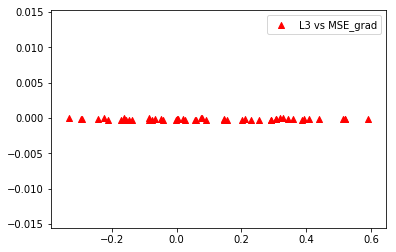

In [120]:
plt.scatter(res[0][0].squeeze(-1).numpy()[::1000], 
            res[0][2].squeeze(-1).numpy()[::1000], 
            marker='^',
            c="r",
            label="L3 vs MSE_grad")
plt.legend(loc='upper right')
plt.show()

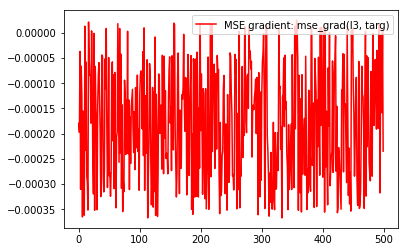

In [121]:
#plt.plot(res[0][0].squeeze(-1).numpy()[::1], label = "Output of the 3rd layer: l3 = l2 @ w2 + b2")
plt.plot(res[0][2].squeeze(-1).numpy()[::100], "r-", label = "MSE gradient: mse_grad(l3, targ)")
plt.legend(loc = "upper right")
plt.show()

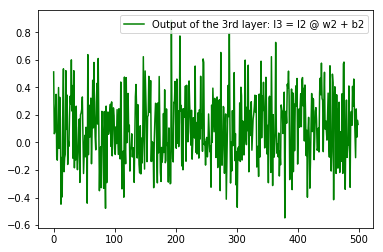

In [122]:
plt.plot(res[0][0].squeeze(-1).numpy()[::100], "g-", label = "Output of the 3rd layer: l3 = l2 @ w2 + b2")
#plt.plot(res[0][2].squeeze(-1).numpy()[::100], label = "MSE gradient: mse_grad(l3, targ)")
plt.legend(loc = "upper right")
plt.show()

# Visualizing MSE gradient

In [123]:
L = 101
lin_arr = torch.linspace(-10,10,L)
#parabola_arr = [elem**2 for elem in lin_arr]
#parabola_arr = torch.tensor(parabola_arr)
targ_arr = torch.zeros(L)
derivative_arr = mse_grad(lin_arr,targ_arr)

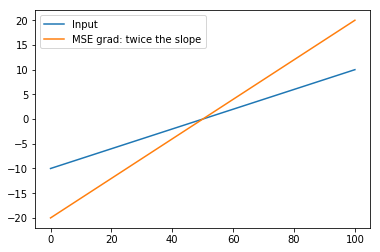

In [124]:
plt.plot(lin_arr, label = "Input")
plt.plot(derivative_arr.squeeze(-1)*L, label = "MSE grad: twice the slope")
plt.legend()
plt.show()

# Visualizing Linear gradient 

In [125]:
len(res)
res[-1]
s = len(res[-1])
print(s)
for kk in range(s):
    print("The shape in dimension {} is {}".format(kk, res[-1][kk].shape))
    print("The array in dimension {} is {}".format(kk, res[-1][kk].squeeze(-1)))
    print("-"*100)

3
The shape in dimension 0 is torch.Size([50000, 784])
The array in dimension 0 is tensor([[ 8.1600e-06, -1.8171e-06, -9.9805e-06,  ...,  4.4138e-06,
         -9.1272e-06,  1.0831e-05],
        [ 3.7698e-08,  1.5436e-08, -6.5063e-09,  ..., -1.4579e-08,
         -5.7551e-09,  1.3242e-08],
        [ 1.5597e-05,  4.8141e-06,  1.9105e-06,  ..., -8.6642e-06,
         -4.2750e-06,  7.1303e-06],
        ...,
        [ 6.5194e-06,  1.3596e-05, -1.3854e-05,  ..., -1.2862e-05,
         -5.3660e-06,  8.4205e-06],
        [ 8.4809e-06,  3.0764e-06, -5.5431e-06,  ...,  8.4704e-06,
          2.6861e-06,  7.6819e-06],
        [ 1.9780e-05,  5.1440e-06, -9.8712e-06,  ..., -1.5498e-05,
         -1.0605e-05,  1.1534e-05]])
----------------------------------------------------------------------------------------------------
The shape in dimension 1 is torch.Size([784, 50])
The array in dimension 1 is tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ...,

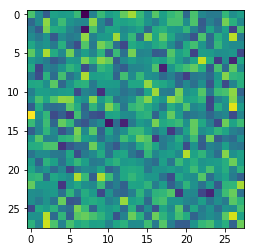

In [126]:
plt.imshow(res[-1][0][0].reshape(28,28))

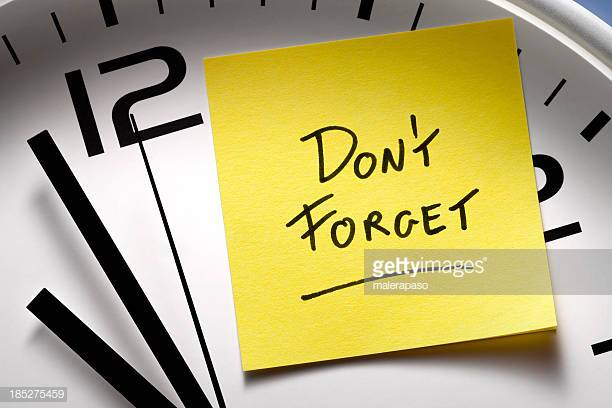

In [127]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "yellow_note1.jpg", width=600)

Note for myself: go over Jeremy Howard paper on matrix calculus 
https://arxiv.org/pdf/1802.01528.pdf

# Comparison 

In [128]:
res = complete_pass(x_tr, y_tr)

In [129]:


w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig = x_tr.g.clone()

In [130]:
xt2 = x_tr.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [131]:
def forward(inp, targ):
    # forward pass:
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    # we don't actually need the loss in backward!
    return mse(out, targ)

In [132]:
loss = forward(xt2, y_tr)

In [133]:
loss.backward()

In [134]:
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [135]:
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [136]:
test_near(w22.grad, w2g)

# Refactoring 

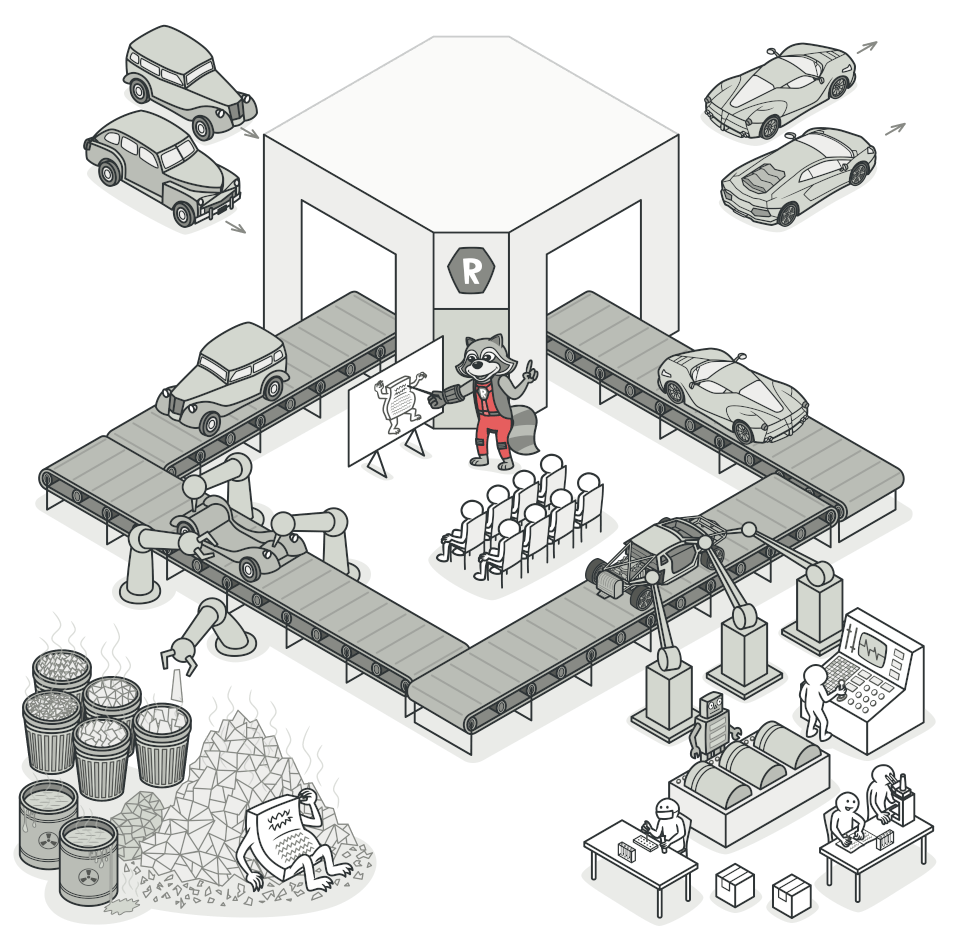

In [137]:
cwd = os.getcwd()
#print("The current path is ", cwd)
Image(filename = cwd + "/cool_images/" + "refactoring1.png", width=600)

In [138]:
class Relu():
    
#     def __init__(self, inp):
    
#         # input is a reserved word man!
    
#         self.inp = inp
        
#         # __init__ returns None -> __call__ instead
        
    def __call__(self, inp):
    
        # input is a reserved word man!
    
        self.inp = inp
        
        # __init__ returns None -> __call__ instead
        
        self.out = self.inp.clamp_min(0.0) - 0.5
        
        return(self.out)
        

    def backward(self):
        
        self.out = self.inp.clamp_min(0.0) - 0.5
        
        self.inp.g = (self.inp > 0).float() 
        
        self.inp.g *= self.out.g
        
        # AttributeError: 'Tensor' object has no attribute 'g'
        
        # we will assign this value later on 

In [139]:
class Lin():
    
    def __init__(self, weight, bias):
        
        self.w, self.b = weight, bias
        
    def __call__(self, inp):
        
        self.inp = inp 
        
        self.out = self.inp @ self.w + self.b
        
        return self.out
        
    def lin_forward(self):
        
        self.out = self.inp @ self.weight + self.bias
        
        return self.out 
    
    def backward(self):
        
        self.inp.g = self.out.g @ self.w.t()
    
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
    
        self.b.g = self.out.g.sum(0)
        
        #return(self.out.g. self.w.g, self.b.g)

In [140]:
class MSE():
    
#     def __init__(self, inp, targ):
        
#         self.inp, self.targ = inp, targ
        
#         self.out = None
        
    def __call__(self, inp, targ):
        
        self.inp, self.targ = inp, targ
        
        self.out = (self.inp.squeeze(-1) - self.targ).pow(2).mean()
        
        return(self.out)
        
    
    
    def mse_error(self):
        
        self.out = (self.inp.squeeze(-1) - self.targ).pow(2).mean()
        
    def backward(self):
        
        self.inp.g = 2.0 * (self.inp.squeeze(-1) - self.targ).unsqueeze(-1) * 1.0/self.inp.shape[0]
        

In [141]:
class Model():
    
    def __init__(self, w1, b1, w2, b2):
        self.layers = []
        self.layers.append(Lin(w1, b1))
        self.layers.append(Relu())
        self.layers.append(Lin(w2, b2))
#         self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = MSE()
        
    def __call__(self, x, targ):
        
        for ll in self.layers: x = ll(x)
            
        return self.loss(x, targ)
    
    def backward(self):
        
        self.loss.backward()
        
        for ll in reversed(self.layers): 
            
            ll.backward()

In [142]:
w1.g, b1.g, w2.g, b2.g = [None] * 4
model = Model(w1, b1, w2, b2)

In [143]:
%time loss = model(x_tr, y_tr)

CPU times: user 474 ms, sys: 19.6 ms, total: 494 ms
Wall time: 120 ms
